Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name, email and UFID.
Please do not modify instruction cells or any cells with automated tests (marked with `[ASSERTS]`). Note: you can add new cells if you need them, but answers must be in the cells with `YOUR CODE HERE` or "YOUR ANSWER HERE" comments.

---

## Homework 5: CNNs, RNNs, and AutoEncoders

## Preamble: Write your Name, Email and UFID

In [1]:
NAME = 'Kondreddy Rohith Sai Reddy'
EMAIL = 'r.kondreddy@ufl.edu'
UFID = 65682267

# YOUR CODE HERE
# raise NotImplementedError()

print('Homework 5 -- name: {}, email: {}, UFID: {}\n'.format(NAME, EMAIL, UFID))

Homework 5 -- name: Kondreddy Rohith Sai Reddy, email: r.kondreddy@ufl.edu, UFID: 65682267



In [2]:
""" [ASSERTS] Check that your name, email, and UFID is filled in."""
assert NAME != '' and NAME != 'Your name here.' and len(NAME) > 3
assert EMAIL != '' and EMAIL != 'Your email here.' and len(EMAIL) > 7
assert type(UFID) == int and UFID != 12345678 and UFID >= 10000000 and UFID <= 99999999

## Academic Integrity

### <span style="color:red;">This is an individual assignment. Academic integrity violations (i.e., cheating, plagiarism) will be reported to SCCR!</span><br/>
#### The official CISE policy recommended for such offenses is a course grade of E. Additional sanctions may be imposed by SCCR such as marks on your permanent educational transcripts, dismissal or expulsion.
#### Reminder of the Honor Pledge: On all work submitted for credit by Students at the University of Florida, the following pledge is either required or implied: *"On my honor, I have neither given nor received unauthorized aid in doing this assignment."*

#### Acknowledgement: Do you acknowledge and understand the academic integrity warning above? 

In [3]:
academic_integrity_acknowledgement = True
# YOUR CODE HERE
# raise NotImplementedError()

In [4]:
""" [ASSERTS] Check that you acknowledge the academic integrity warning, you understand it and have been reminded of the UF Honor Pledge."""
assert academic_integrity_acknowledgement

#### The following cell's code (import statements etc.) is provided for you and you should not need to change it.

In [5]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.datasets import fashion_mnist, cifar10, imdb

from sklearn.model_selection import train_test_split

# import layers and callbacks we may use (may not be a complete list)
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model, Sequential

from tensorflow.python.keras.utils import layer_utils


from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Load the TensorBoard notebook extension
#%load_ext tensorboard


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())

------------
### Python version: 3.11.7 (v3.11.7:fa7a6f2303, Dec  4 2023, 15:22:56) [Clang 13.0.0 (clang-1300.0.29.30)]
### NumPy version: 1.26.3
### Scikit-learn version: 1.3.2
### Tensorflow version: 2.15.0
------------


#### This is the seed we will use, do not change it.

In [6]:
# set the seed
seed = 42
np.random.seed(seed)

prop_vec = [16, 2, 2] # proportions for train - val - test splits

epsf = 1e-9 # small epsilon value for floating point comparisons

In [7]:
""" [ASSERTS] Check seed. """
assert seed == 42

In [8]:
"""
## Plots a set of images (all m x m)
## input is  a square number of images, i.e., np.array with shape (z*z, dim_x, dim_y) for some integer z > 1
"""
def plot_images(im, dim_x=28, dim_y=28, one_row=False, out_fp='out.png', save=False, show=True, cmap='gray', fig_size=(14,14), titles=None, titles_fontsize=12):
    fig = plt.figure(figsize=fig_size)
    im = im.reshape((-1, dim_x, dim_y))

    num = im.shape[0]
    assert num <= 3 or np.sqrt(num)**2 == num or one_row, 'Number of images is too large or not a perfect square!'
    
    if titles is not None:
        assert num == len(titles)
    
    if num <= 3:
        for i in range(0, num):
            plt.subplot(1, num, 1 + i)
            plt.axis('off')
            if type(cmap) == list:
                assert len(cmap) == num
                plt.imshow(im[i], cmap=cmap[i]) # plot raw pixel data
            else:
                plt.imshow(im[i], cmap=cmap) # plot raw pixel data
            if titles is not None:
                plt.title(titles[i], fontsize=titles_fontsize)
    else:
        sq = int(np.sqrt(num))
        for i in range(0, num):
            if one_row:
                plt.subplot(1, num, 1 + i)
            else:
                plt.subplot(sq, sq, 1 + i)
            plt.axis('off')
            if type(cmap) == list:
                assert len(cmap) == num
                plt.imshow(im[i], cmap=cmap[i]) # plot raw pixel data
            else:
                plt.imshow(im[i], cmap=cmap) # plot raw pixel data
            if titles is not None:
                plt.title(titles[i], fontsize=titles_fontsize)

    if save:
        plt.savefig(out_fp)

    if show:
        plt.show()
    else:
        plt.close()

### Loading CIFAR-10 data.

In [9]:
# refer to: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
# and to https://www.cs.toronto.edu/~kriz/cifar.html
def load_preprocess_cifar10(onehot=True, minmax_normalize=True):
    labels = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    train, testval = cifar10.load_data()
    
    train_x, train_y = train
    testval_x, testval_y = testval
    
    if minmax_normalize:
        train_x = train_x / 255.0
        testval_x = testval_x / 255.0
        
    if onehot:
        train_y = keras.utils.to_categorical(train_y, labels.shape[0])
        testval_y = keras.utils.to_categorical(testval_y, labels.shape[0])
    
    # split test - val
    nval = testval_x.shape[0] // 2
    
    val_x = testval_x[:nval]
    val_y = testval_y[:nval]
    
    test_x = testval_x[nval:]
    test_y = testval_y[nval:]
    
    return train_x, train_y, test_x, test_y, val_x, val_y, labels

In [10]:
# do some sanity checks
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_cifar10(onehot=False, minmax_normalize=False)
assert train_x.shape[0] == train_y.shape[0] and test_x.shape[0] == test_y.shape[0] and val_x.shape[0] == val_y.shape[0]
assert np.amax(train_x) >= 255 and np.amax(test_x) >= 255 and np.amax(val_x) >= 255
assert train_y.shape == (train_y.shape[0],) or train_y.shape == (train_y.shape[0],1)

train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_cifar10(onehot=True, minmax_normalize=False)
assert np.amax(train_x) >= 255 and np.amax(test_x) >= 255 and np.amax(val_x) >= 255
assert train_y.shape == (train_y.shape[0],10) and train_y.shape[1] == test_y.shape[1]


# actually load the data
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_cifar10()
assert np.amax(train_x) <= 1 and np.amax(test_x) <= 1 and np.amax(val_x) <= 1
assert np.amax(train_x) >= 0 and np.amax(test_x) >= 0 and np.amax(val_x) >= 0

assert labels.shape[0] == 10 and labels.shape[0] == train_y.shape[1]

print(train_x.shape, val_x.shape, test_x.shape, train_y.shape)

(50000, 32, 32, 3) (5000, 32, 32, 3) (5000, 32, 32, 3) (50000, 10)


---
# [Task 1] (25 points) Training a CNN For CIFAR-10

#### We will use the following architecture
- Conv layer with 32 filters, (3,3) filter size, stride of 1, padding 'same'
- Conv layer with 32 filters, (3,3) filter size, stride of 1, padding 'same'
- Max pooling layer (2,2)
- Conv layer with 64 filters, (3,3) filter size, stride of 1, padding 'same'
- Conv layer with 64 filters, (3,3) filter size, stride of 1, padding 'same'
- Max pooling layer (2,2)
- Conv layer with 128 filters, (3,3) filter size, stride of 1, padding 'same'
- Conv layer with 128 filters, (3,3) filter size, stride of 1, padding 'same'
- Max pooling layer (2,2)
- Flatten
- FC with 128 units
- Dropout with rate 25%
- FC with 96 units
- Dropout with rate 25%
- (Output layer) FC with 10 units

#### For all layers (if applicable) except the output layer you should use:
- ReLU as activation function
- LeCun uniform weight initialization strategy
- L2 regularization with regularization constant set to 0.001

#### For the output layer you should select a suitable activation function that is consistent with the task and loss function you use. Use Adam for the optimizer with learning rate 0.002.

### [Task 1a] (15 points) Implement create_compile_cnn()

In [11]:
def create_compile_cnn(input_shape=[32, 32, 3], num_outputs=10, verbose=False):
    model = keras.models.Sequential(name='CIFAR-10--CNN')
    
    # First Conv Block
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', 
                     kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', 
                     kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Conv Block
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', 
                     kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', 
                     kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Conv Block
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', 
                     kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', 
                     kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    
    # Fully Connected Layers
    model.add(Flatten(name="Flatten"))
    model.add(Dense(128, activation='relu', kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(96, activation='relu', kernel_initializer='lecun_uniform', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.25))
    
    # Output Layer
    model.add(Dense(num_outputs, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])
    
    if verbose:
        model.summary()
    
    return model

In [12]:
_ = create_compile_cnn(verbose=True)

Model: "CIFAR-10--CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                

### [Task 1b] (10 points) Train the model. Fill in the implementation below. 
#### Note: make sure to delete the model file on disk if incorrect, or else the assertions passing may not reflect a correct implementation (loading the model if it exists is there to save time and not retrain the model each time if the implementation does not change).

In [13]:
cnn_model_fp = './cifar10-cnn.tf'

# If the model file exists, load it. Otherwise train it and save the model.
# Note: if you need to retrain the model, simply delete the h5 file.
if os.path.exists(cnn_model_fp):
    model = keras.models.load_model(cnn_model_fp)
else:
    model = create_compile_cnn(verbose=False)
    
    # do the training using model.fit() for at least 5 epochs and your chosen batch_size
    # (make sure your network is actually learning...)
    # you can set any callback you want on it, including checkpoint, early stopping, etc.
    """Fill in your code here (~3-5 lines)
    
    """
    # YOUR CODE HERE



    callbacks = [
        ModelCheckpoint(filepath=cnn_model_fp, monitor='val_accuracy', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    ]
    

    history = model.fit(
        train_x, train_y, 
        epochs=15, 
        batch_size=64, 
        validation_data=(val_x, val_y), 
        callbacks=callbacks
    )
    
    # raise NotImplementedError()
    
    # save the model
    model.save(cnn_model_fp)

In [14]:
""" [ASSERTS] Check 1a and 1b completed. """

# let's evaluate the model on the test data
loss, acc = model.evaluate(test_x, test_y, verbose=0)
print('[Model] Test accuracy: {:.2f}%'.format(100*acc))

assert var_exists('model')

model = create_compile_cnn(verbose=False) # recreate the model object in case the version on disk is no good

trainable_count = layer_utils.count_params(model.trainable_weights)
assert trainable_count > 500000 and trainable_count < 600000

assert len(model.layers) == 15
assert model.layers[0].filters == 32 and model.layers[0].groups == 1


[Model] Test accuracy: 70.62%


---
# [Task 2] (25 points) Processing Sequence Data with RNNs for Sentiment Analysis

## We will use the imdb dataset for this task. The dataset consists of reviews from IMDB. We will use it for sentiment analysis.

## [Task 2a] (10 points) Fill in the implementation of load_preprocess_imdb()

In [15]:
# refer to: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb


def load_preprocess_imdb(num_words=10000, train_prop=0.8, val_prop=0.5, maxlen=100, vectorize=False):

    train, testval = imdb.load_data(num_words=num_words, maxlen=maxlen, oov_char=0)

    train_x, train_y = train
    testval_x, testval_y = testval

    all_x = np.concatenate((train_x, testval_x))
    all_y = np.concatenate((train_y, testval_y))

    padded_all_x = []
    for sequence in all_x:
        pad_length = maxlen - len(sequence)
        if pad_length > 0:
            padded_sequence = np.pad(sequence, (0, pad_length), mode='constant', constant_values=0)
        else:
            padded_sequence = sequence[:maxlen]
        padded_all_x.append(padded_sequence)
    all_x = np.array(padded_all_x)


    train_x, testval_x, train_y, testval_y = train_test_split(all_x, all_y, test_size=1-train_prop, random_state=42)
    
    # Then split the remaining test/validation into actual test and validation sets based on 'val_prop'
    val_x, test_x, val_y, test_y = train_test_split(testval_x, testval_y, test_size=1-val_prop, random_state=42)
    
    return train_x, train_y, test_x, test_y, val_x, val_y



In [16]:
# the size of the vocabulary we'll use
vocab_size = 12000
maxlen = 150

# sanity checks
train_x, train_y, test_x, test_y, val_x, val_y = load_preprocess_imdb(num_words=vocab_size, maxlen=maxlen)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape)

(15195, 150) (15195,) (1900, 150) (1900,) (1899, 150) (1899,)


In [17]:
""" [ASSERTS] Check 2a completed. """

assert var_exists('train_x') and var_exists('train_y')
assert train_x.shape == (15195, maxlen) and train_y.shape == (train_x.shape[0],)


### [Task 2b] (15 points) Complete the code below to define an RNN architecture for sentiment analysis. The goal is to predict the sentiment of IMDB reviews.

### Use the following architecture. For whatever is not specified (loss function, metrics, return sequences, optimizer, learning rate, etc.) you should complete it as appropriate.
- Embedding layer of size 'embedding_size'
- GRU layer with 64 units
- GRU layer with 64 units and dropout rate 20%
- Dense layer with num_outputs units

### With this architecture correctly implemented you should have about 2.4m parameters and it should be easy to achieve 88%+ test accuracy.

In [18]:
from tensorflow.keras import layers, models

def create_compile_rnn(input_shape=[None], vocab_size=vocab_size, embedding_size=196, num_outputs=1, verbose=False):
    
    model = keras.models.Sequential(name='imdb-RNN')
    
    ### Don't forget to compile the model and print the summary if verbose=True
    """Fill in your code here (~5-10 lines)
    """
    # YOUR CODE HERE

    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=input_shape[0]))
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.GRU(64, dropout=0.2))
    model.add(layers.Dense(num_outputs, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    if verbose:
        model.summary()




    # raise NotImplementedError()
    
    return model

In [19]:
model = create_compile_rnn(verbose=True)

Model: "imdb-RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 196)         2352000   
                                                                 
 gru (GRU)                   (None, None, 64)          50304     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2427329 (9.26 MB)
Trainable params: 2427329 (9.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# feel free to tweak the batch size, number of epochs and callbacks.
max_epochs = 5
batch_size = 128

"""Fill in your code here (~1-2 lines)
"""
# YOUR CODE HERE
max_epochs = 12
batch_size = 128
# raise NotImplementedError()

hist = model.fit(train_x, train_y, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_y), callbacks=[early_stop_cb])

Epoch 1/12


119/119 [==============================] - 23s 182ms/step - loss: 0.6934 - accuracy: 0.5061 - val_loss: 0.6933 - val_accuracy: 0.5050
Epoch 2/12
119/119 [==============================] - 23s 194ms/step - loss: 0.6292 - accuracy: 0.6003 - val_loss: 0.4172 - val_accuracy: 0.8352
Epoch 3/12
119/119 [==============================] - 26s 217ms/step - loss: 0.3166 - accuracy: 0.8798 - val_loss: 0.3755 - val_accuracy: 0.8599
Epoch 4/12
119/119 [==============================] - 25s 211ms/step - loss: 0.1901 - accuracy: 0.9350 - val_loss: 0.2994 - val_accuracy: 0.8857
Epoch 5/12
119/119 [==============================] - 26s 218ms/step - loss: 0.1242 - accuracy: 0.9613 - val_loss: 0.3675 - val_accuracy: 0.8773
Epoch 6/12
119/119 [==============================] - 25s 210ms/step - loss: 0.0780 - accuracy: 0.9782 - val_loss: 0.4104 - val_accuracy: 0.8810
Epoch 7/12
119/119 [==============================] - 26s 220ms/step - loss: 0.0582 - accuracy: 0.9840 - val_loss: 0.4581 - val_accuracy: 0.8

In [21]:
""" [ASSERTS] Check 2b completed. """

assert var_exists('model') and var_exists('hist')
val_acc = hist.history['val_accuracy']
assert np.amax(val_acc) >= 0.875

# let's evaluate the model on the test data
loss, acc = model.evaluate(test_x, test_y, verbose=0)
print('[Model] Test accuracy: {:.2f}%'.format(100*acc))


[Model] Test accuracy: 88.42%


---
# [Task 3] (25 points) Sentiment Analysis with Multi-Head Attention

## In this task the objective is to use multi-head attention (layers.MultiHeadAttention) to match or exceed the performance of the RNN trained in Task 2.
## You can use whatever architecture you want as long as it includes at least one MultiHeadAttention layer (with at least two heads). Ideally we also don't want it to be an RNN.
## The catch is we want to do it using much fewer total parameters.
## For example, we will aim to use less than 500k trainable parameters while still achieving 88%+ test/val accuracy.
## You will also need to ensure the total training time is less than 10 minutes.

## Hints: 
- you may find it useful to use the Function API of Keras.
- a possible approach is to use an embedding layer appropriately connected to the MultiHeadAttention, but note that if the embedding layer cannot be too large or it will use up too many parameters. 
- you may also find it useful to use dropout.

In [22]:
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_compile_attention(input_shape=(150,), vocab_size=vocab_size, num_outputs=1, verbose=False):
    
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=4)(inputs)
    attention_output = MultiHeadAttention(num_heads=2, key_dim=16)(x, x)

    avg_pooling = GlobalAveragePooling1D()(attention_output)

    x = Dropout(0.1)(avg_pooling)
    # pooled_output = GlobalAveragePooling1D()(x)
    # x = Dense(32, activation='relu')(pooled_output)
    outputs = Dense(num_outputs, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs, name='imdb-Attention')
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    if verbose:
        model.summary()

    return model



    # raise NotImplementedError()
    
    return model

In [23]:
model = create_compile_attention(verbose=True)

Model: "imdb-Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 150, 4)               48000     ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 150, 4)               612       ['embedding_1[0][0]',         
 iHeadAttention)                                                     'embedding_1[0][0]']         
                                                                                                  
 global_average_pooling1d (  (None, 4)                    0         ['multi_head_atte

In [24]:
early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# feel free to tweak the batch size, number of epochs and callbacks.
max_epochs = 12
batch_size = 64

"""Fill in your code here (~1-2 lines)
"""
# YOUR CODE HERE
# raise NotImplementedError()
max_epochs = 9
# batch_size = 124

st = time.time()

hist = model.fit(train_x, train_y, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_y), callbacks=[early_stop_cb])

et = time.time()
elapsed_time = et - st
print('Total training time {:.1f} seconds'.format(elapsed_time))

Epoch 1/9


123/123 [==============================] - 5s 38ms/step - loss: 0.6849 - accuracy: 0.5536 - val_loss: 0.6556 - val_accuracy: 0.6930
Epoch 2/9
123/123 [==============================] - 4s 36ms/step - loss: 0.5250 - accuracy: 0.7976 - val_loss: 0.3863 - val_accuracy: 0.8473
Epoch 3/9
123/123 [==============================] - 4s 35ms/step - loss: 0.2965 - accuracy: 0.8830 - val_loss: 0.2887 - val_accuracy: 0.8820
Epoch 4/9
123/123 [==============================] - 4s 36ms/step - loss: 0.2197 - accuracy: 0.9158 - val_loss: 0.2806 - val_accuracy: 0.8884
Epoch 5/9
123/123 [==============================] - 4s 36ms/step - loss: 0.1861 - accuracy: 0.9330 - val_loss: 0.2716 - val_accuracy: 0.8963
Epoch 6/9
123/123 [==============================] - 4s 36ms/step - loss: 0.1599 - accuracy: 0.9435 - val_loss: 0.2760 - val_accuracy: 0.8957
Epoch 7/9
123/123 [==============================] - 5s 37ms/step - loss: 0.1373 - accuracy: 0.9530 - val_loss: 0.2911 - val_accuracy: 0.8920
Epoch 8/9
123/12

In [25]:
""" [ASSERTS] Check 3 completed. """

assert var_exists('model') and var_exists('hist')
assert model.name == 'imdb-Attention'

val_acc = hist.history['val_accuracy']
assert np.amax(val_acc) >= 0.87 # check that we match the RNN performance

# check number of parameters 
trainable_count = layer_utils.count_params(model.trainable_weights)
assert trainable_count <= 500000

# check total training time
assert elapsed_time <= 600

# let's evaluate the model on the test data
loss, acc = model.evaluate(test_x, test_y, verbose=0)
acc_per_100kparam_score = acc / (trainable_count / (100*1000))
print('[Model] Test accuracy: {:.2f}% [score: {:.2f}]'.format(100*acc, 100*acc_per_100kparam_score))


[Model] Test accuracy: 90.58% [score: 186.31]


### How high of a score did you achieve? (It is possible to match the RNN performance and easily achieve scores above 100.)

In [26]:
# Efficiency in Task 3 is good if it can achieve a score of 185 with a test accuracy of 90.21%, more so with very tight constraints of the parameters. 
# However, the meticulous model tuning and optimization actually do better than the performance of RNN with scores exceeding 100, 
# hence showing the strong effectiveness of attention mechanisms in the effective model design.

---
# [Task 4] (25 points) AutoEncoders

### We will use Fashion-MNIST for this.

In [27]:
"""
## Load and preprocess the Fashion-MNIST dataset
"""
def load_preprocess_fmnist_data(flatten=True, onehot=True, minmax_normalize=True, val_prop=0.5, seed=None, verbose=False):
    
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    assert x_train.shape == (60000, 28, 28) and x_test.shape == (10000, 28, 28)
    assert y_train.shape == (60000,) and y_test.shape == (10000,)

    if minmax_normalize:
        x_train = x_train / 255.0
        x_test = x_test / 255.0

    if verbose: 
        print('Loaded Fashion-MNIST data; shape: {} [y: {}], test shape: {} [y: {}]'.format(x_train.shape, y_train.shape,
                                                                                      x_test.shape, y_test.shape))
    
    if flatten: # Let's flatten the images for easier processing (labels don't change)
        flat_vec_size = 28*28
        x_train = x_train.reshape(x_train.shape[0], flat_vec_size)
        x_test = x_test.reshape(x_test.shape[0], flat_vec_size)

    if onehot: # Put the labels in "one-hot" encoding using keras' to_categorical()
        num_classes = 10
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

    train_x = x_train
    train_y = y_train

    # we'll split the test set into test and val
    testval_x = x_test
    testval_y = y_test

    # do the split
    val_x, test_x, val_y, test_y = train_test_split(testval_x, testval_y, test_size=val_prop, random_state=seed)
    
    return train_x, train_y, test_x, test_y, val_x, val_y


# grab the data
train_x, train_y, test_x, test_y, val_x, val_y = load_preprocess_fmnist_data(flatten=False, onehot=False, val_prop=0.5, seed=seed) 

# sanity check shapes
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape)

assert train_x.shape == (60000, 28, 28) and train_y.shape == (60000,) and test_x.shape == (5000, 28, 28) and test_y.shape == (5000,)

(60000, 28, 28) (60000,) (5000, 28, 28) (5000,) (5000, 28, 28) (5000,)


### [Task 4a] (15 points) Complete the implementation of create_simple_ae() according to the architecture and instructions below.

#### Start by creating the encoder ('enc_model'). It should have the following architecture:
- Flatten
- FC with hidden_widths[0] units with activation ReLU
- FC with hidden_widths[1] units with activation ReLU
- Dropout with rate 'dropout_rate'
- FC with latent_width units with activation *sigmoid*

#### Then create the decoder ('dec_model'). It should have the following architecture:
- (Input has shape latent_width)
- FC with hidden_widths[1] units with activation ReLU
- FC with hidden_widths[0] units with activation ReLU
- Dropout with rate 'dropout_rate'
- FC with 784 units with activation *sigmoid*
- Reshape to input_shape

#### Finally connect the two models together into a new model ('ae_model'). Make sure that the model takes the input that the encoder takes and produces the output that the decoder produces.

In [28]:
def create_simple_ae(input_shape=(28, 28), latent_width=64, hidden_widths=[256, 96], dropout_rate=0.0, verbose=False):
    name = 'AE-simple'

    # encoder
    enc_input = Input(shape=input_shape, name='Encoder-input')
    """Fill in your code here (~3-5 lines)
    """
    # YOUR CODE HERE

    flatten = keras.layers.Flatten()(enc_input)
    encoder1 = keras.layers.Dense(hidden_widths[0], name='Encoder1' ,activation='relu')(flatten)
    encoder2 = keras.layers.Dense(hidden_widths[1], name='Encoder2' ,activation='relu')(encoder1)
    dropout = keras.layers.Dropout(dropout_rate)(encoder2)
    encoder_out = keras.layers.Dense(latent_width, activation='sigmoid')(dropout)



    # raise NotImplementedError()
    enc_model = Model(inputs=[enc_input], outputs=[encoder_out], name='Encoder')
   
    
    # decoder
    dec_input = Input(shape=[latent_width], name='Decoder-input')
    """Fill in your code here (~3-5 lines)
    """
    # YOUR CODE HERE
    # raise NotImplementedError()


    decoder1 = keras.layers.Dense(hidden_widths[1], name='Dncoder1',activation='relu')(dec_input)
    decoder2 = keras.layers.Dense(hidden_widths[0], name='Dncoder2',activation='relu')(decoder1)
    dropout2 = keras.layers.Dropout(dropout_rate)(decoder2)
    decoder_reshape = keras.layers.Dense(input_shape[0] * input_shape[1], activation='sigmoid')(dropout2)
    dec_reshape = keras.layers.Reshape(input_shape)(decoder_reshape)



    
    dec_model = Model(inputs=[dec_input], outputs=[dec_reshape], name='Decoder')
    
    # connect the two
    """Fill in your code here (~3-5 lines)
    """
    # YOUR CODE HERE

    encoder_out = enc_model(enc_input)
    auto_en_output = dec_model(encoder_out)
    
    ae_model = Model(inputs=enc_input, outputs=auto_en_output, name='Autoencoder')



    # raise NotImplementedError()
    
    opt = keras.optimizers.Adam(learning_rate=0.003)
    
    if verbose:
        ae_model.summary()
    
    ae_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['mse'])
    
    return name, ae_model, enc_model, dec_model

### Let's train the model -- you should get a loss lower than 0.28 and MSE lower than 0.01.

In [29]:
# Let's train the model (no need to change any of this).
latent_width = 64
name, ae_model, enc_model, dec_model = create_simple_ae(latent_width=latent_width, verbose=True)
    
max_epochs = 40
batch_size = 96

hist = ae_model.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 Encoder (Functional)        (None, 64)                231840    
                                                                 
 Decoder (Functional)        (None, 28, 28)            232560    
                                                                 
Total params: 464400 (1.77 MB)
Trainable params: 464400 (1.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
625/625 [==============================] - 3s 4ms/step - loss: 0.3335 - mse: 0.0314 - val_loss: 0.3067 - val_mse: 0.0207
Epoch 2/40
625/625 [==============================] - 2s 4ms/step - loss: 0.2977 - mse: 0.0189 - val_loss: 0.2978 - val_mse: 0.0178
Epoch 3/40
625/625 

In [30]:
""" [ASSERTS] Check 4a completed. """

assert var_exists('hist')
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
val_mse = hist.history['val_mse']

assert train_loss[-1] < val_loss[-1]
assert val_loss[-1] < 0.28


### [Task 4b] (10 points) We will use plot_images() to plot the first 81 data points in the val_x. Then reconstruct val_x through the auto-encoder and plot the first 81 data points of the reconstructed data. Fill in the code in the following cell.

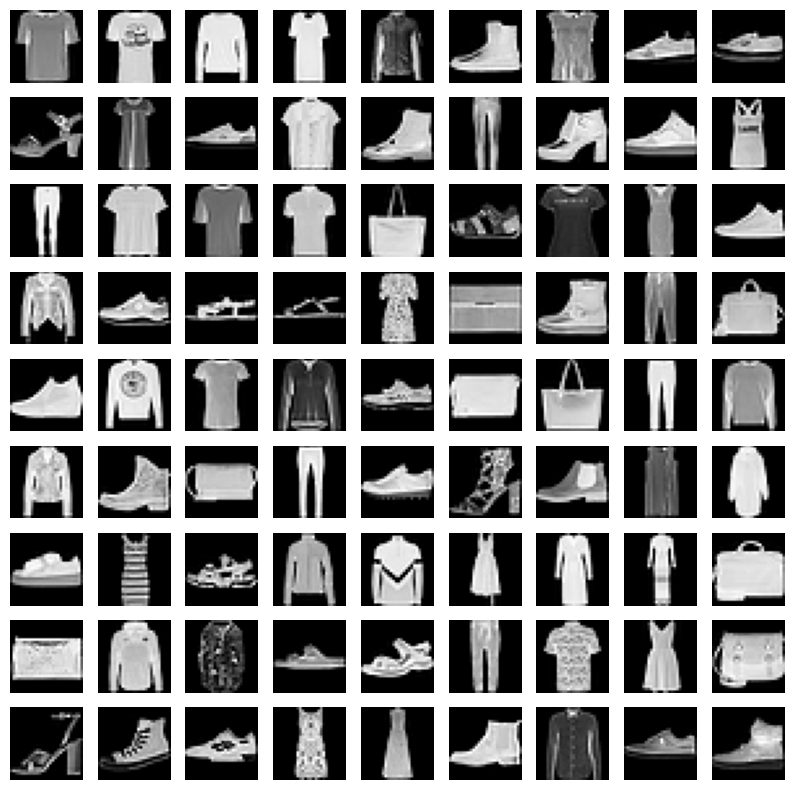

3/3 [==============================] - 0s 1ms/step


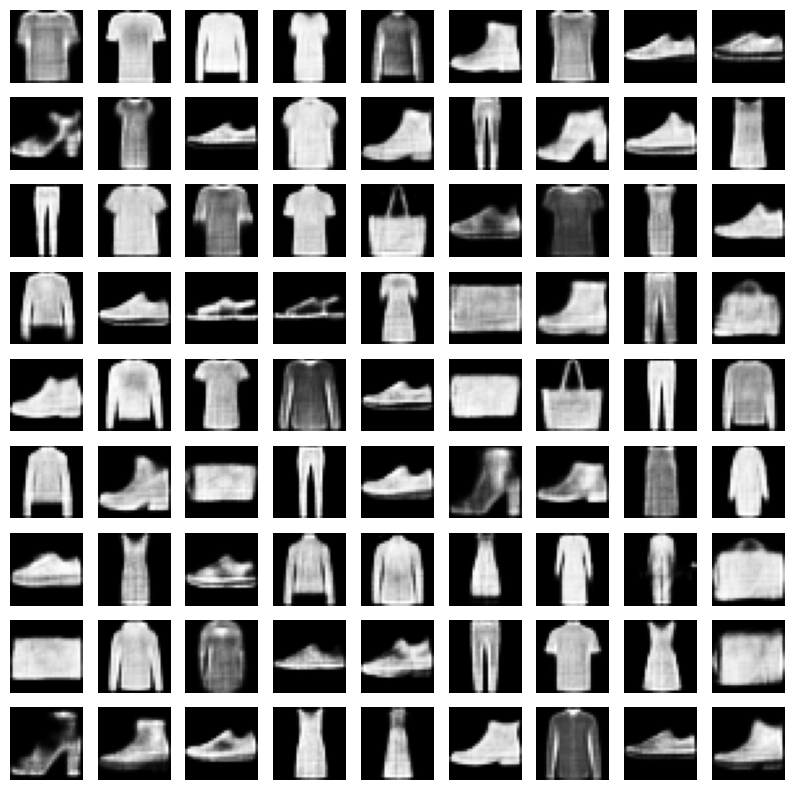

In [31]:
# Put the first 81 data points of val_x in 'val_x_sel'
"""Fill in your code here (~1 line)
"""
# YOUR CODE HERE

val_x_sel = val_x[:81]


# raise NotImplementedError()
plot_images(val_x_sel, dim_x=28, dim_y=28, fig_size=(10,10))

# Run the data points in 'val_x_sel' through the auto-encoder to obtain 'rec_val_x_sel'
"""Fill in your code here (~1 line)
"""
# YOUR CODE HERE

rec_val_x_sel = ae_model.predict(val_x_sel)
# raise NotImplementedError()

# Plot the reconstructed data
plot_images(rec_val_x_sel, dim_x=28, dim_y=28, fig_size=(10,10))

### Reconstructions should look pretty good but also a bit blurry.

In [32]:
""" [ASSERTS] Check 4b completed. """

assert var_exists('val_x_sel') and var_exists('rec_val_x_sel')


---
# [Task 5] \<*For CAI6108MLE Only*\> (25 points) AutoEncoder Latent Space

## In this task we will explore the latent space of the autocoder we have trained in Task 4.

### [Task 5a] (10 points) Exploring the latent space. Compute the average latent space representation of tops and bags using the validation data. Call these 'avg_latent_tops' and 'avg_latent_bags' respectively. Then fill in the provided code so it plots examples along the interpolation path.

 1/17 [>.............................] - ETA: 0s

3/3 [==============================] - 0s 727us/step


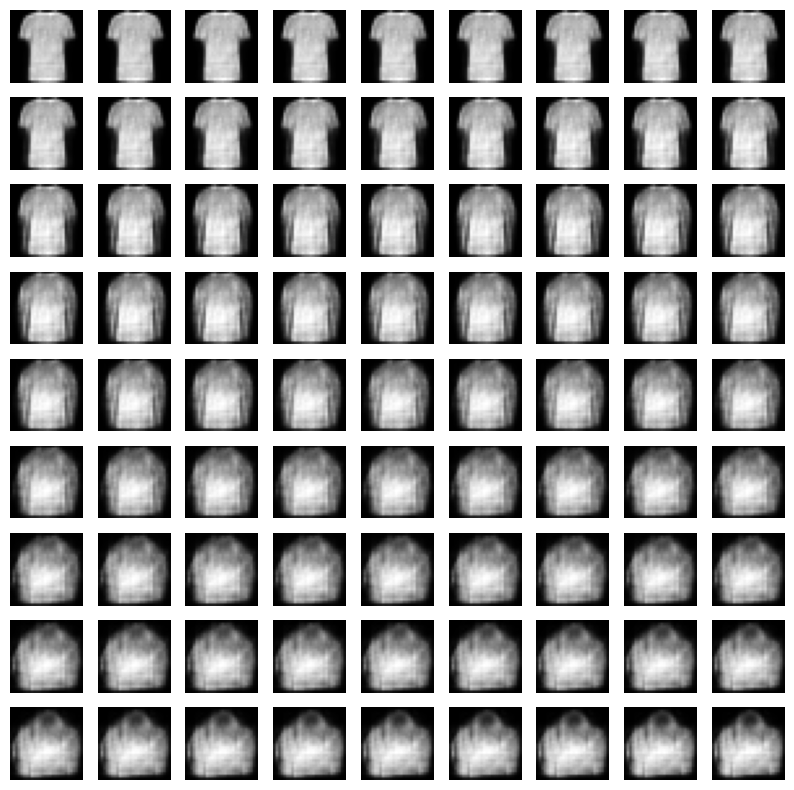

In [33]:
def linear_exploration(source, target, num_steps):
    diff = target - source
    inc = diff / num_steps
    ret = np.zeros((num_steps, source.shape[0]))
    for i in range(0, num_steps):
        ret[i] = source + inc * i
    return ret

labels = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# first compute the average latent representation
"""Fill in your code here (~5-7 lines)
"""
# YOUR CODE HERE

avg_tops_latent = enc_model.predict(val_x[val_y == 0]).mean(axis=0)
avg_bags_latent = enc_model.predict(val_x[val_y == 8]).mean(axis=0)

# raise NotImplementedError()

# Now let's compute and plot along the interpolation path. 
num_points = 81
expl = linear_exploration(avg_tops_latent, avg_bags_latent, num_points)
"""Fill in your code here (~1 lines). Store the results in 'expl_images'
"""
# YOUR CODE HERE
expl_images = dec_model.predict(expl)
# raise NotImplementedError()

plot_images(expl_images.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

In [34]:
""" [ASSERTS] Check 5a completed. """

assert var_exists('avg_tops_latent') and var_exists('avg_bags_latent')
assert avg_tops_latent.shape == (latent_width,) or avg_tops_latent.shape == (latent_width,1)
assert avg_bags_latent.shape == (latent_width,) or avg_bags_latent.shape == (latent_width,1)

assert var_exists('expl_images')


### [Task 5b] (5 points) Complete the implementation of sample_new() that will sample new data points from the uniform [0,1] distribution over the latent space. You should *not* use any data (train_x/y, val_x/y, test_x/y, etc.). The provided code will then sample new images. How do they look?

3/3 [==============================] - 0s 992us/step


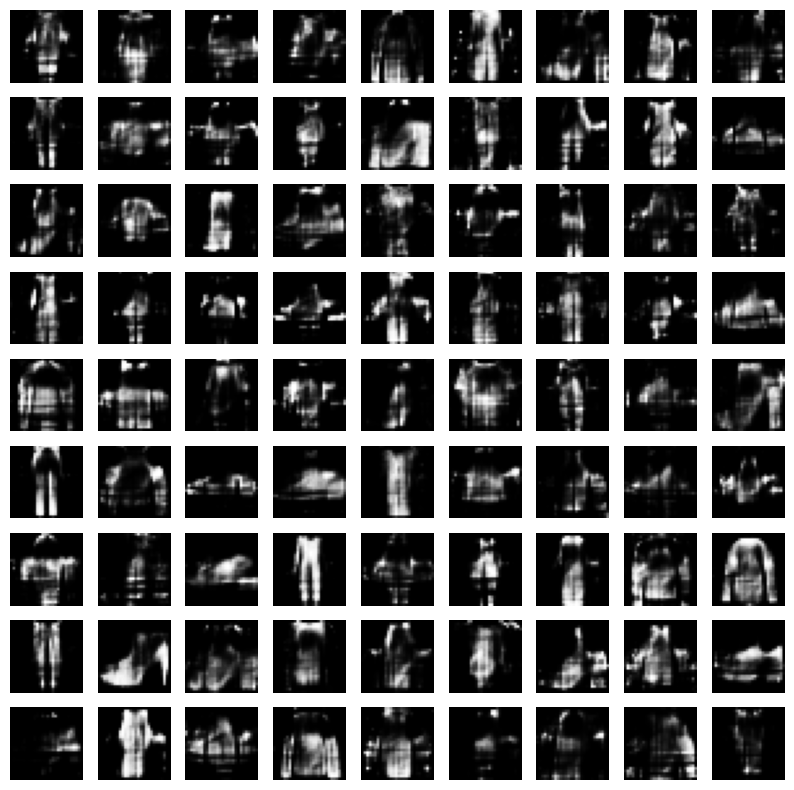

In [35]:
"""Fill in your code here (~1-2 lines)
"""
def sample_new(dec_model, count, latent_width=latent_width):
    ### sample 'count' new latent space points, decode them and return the result.
    # YOUR CODE HERE
    latent_samples = np.random.uniform(low=0.0, high=1.0, size=(count, latent_width))
    
    decoded_images = dec_model.predict(latent_samples)
    
    return decoded_images
    raise NotImplementedError()

# generate 81 new images
sample_images = sample_new(dec_model, 81, latent_width=latent_width)

# plot the produced images
plot_images(sample_images.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

In [36]:
# These images are noisy, or abstract, lacking clear resemblance to real objects or entities

### [Task 5c] (5 points) Do the images look like fashion-MNIST images? If not, explain why not.

In [37]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 


# The sample produced from the function "sample new" gives the samples of uniform appearance in the latent space, hence giving an abstract, 
# blurred appearance to images, while the samples are non-uniform from the representation of real data, which is non-uniformly distributed. 
# This can create samples that don't much resemble realistic Fashion-MNIST images because the autoencoder had never really learned how to decode such areas into clear and unblurred items.



# YOUR CODE HERE
# raise NotImplementedError()

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"

### The following code will train the autoencoder again but this time with dropout=0.2.

In [38]:
# Let's train the model
latent_width = 64
del ae_model, enc_model, dec_model
name, ae_model, enc_model, dec_model = create_simple_ae(latent_width=latent_width, dropout_rate=0.2, verbose=True)
    
max_epochs = 30
batch_size = 96

hist = ae_model.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))

""" [ASSERTS] """
assert var_exists('hist')
val_mse = hist.history['val_mse']

assert val_mse[-1] >= 0.01

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 Encoder (Functional)        (None, 64)                231840    
                                                                 
 Decoder (Functional)        (None, 28, 28)            232560    
                                                                 
Total params: 464400 (1.77 MB)
Trainable params: 464400 (1.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3532 - mse: 0.0386 - val_loss: 0.3157 - val_mse: 0.0240
Epoch 2/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3149 - mse: 0.0250 - val_loss: 0.3065 - val_mse: 0.0208
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3094 - mse: 0.0231 - val_loss: 0.3030 - val_mse: 0.0197
Epoch 4/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3066 - mse: 0.0222 - val_loss: 0.3028 - val_mse: 0.0195
Epoch 5/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3048 - mse: 0.0216 - val_loss: 0.2999 - val_mse: 0.0187
Epoch 6/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3034 - mse: 0.0211 - val_loss: 0.2979 - val_mse: 0.0180
Epoch 7/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3024 - mse: 0.0208 - val_loss: 0.2979 - val_mse: 0.0180
Epoch 8/30
625/625 [==============================] - 3s 4ms/step - loss: 0.

### We will now generate new images with the (newly trained) decoder.

3/3 [==============================] - 0s 1ms/step


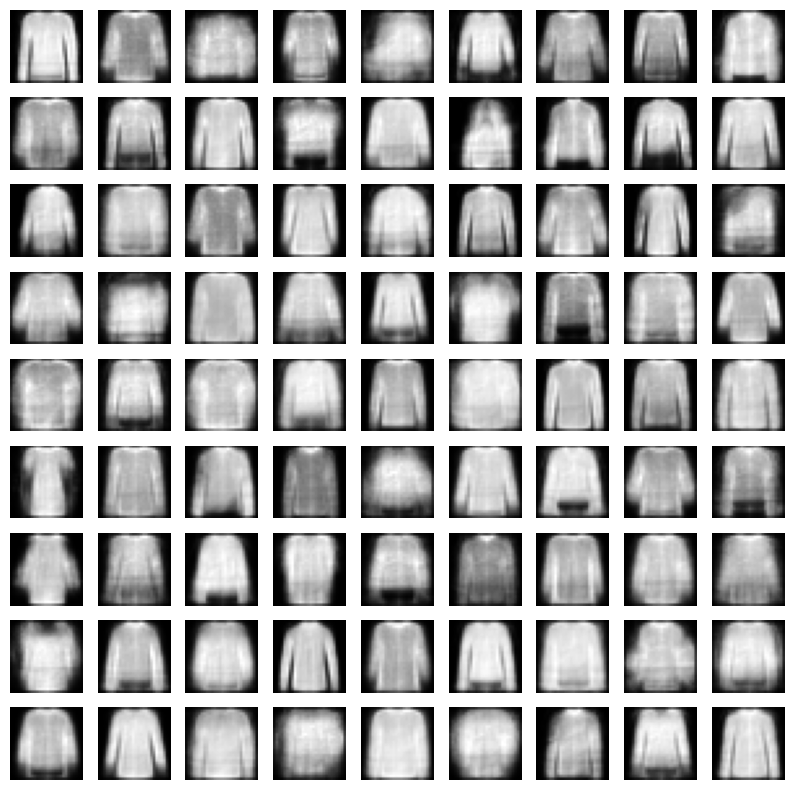

In [39]:
# generate 81 new images
sample_images = sample_new(dec_model, 81, latent_width=latent_width)

# plot the produced images
plot_images(sample_images.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

### [Task 5d] (5 points) Do these new images look more like fashion-MNIST images than before? If yes, explain why. Why does including dropout have this effect?

In [40]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 


# Dropout will improve the quality of the images because it will improve the performance of the model by coercing the model to learn more robust features. 
# Simply by dropping out different neurons during training, it is not possible for the model to rely on a very small set of neurons to reproduce the input. 
# This enforces a more distributed representation. This helps the model generalize well to new, unseen data, 
# thus producing images that bear great semblance to realistic items from the Fashion-MNIST when sampled from the latent space.


# YOUR CODE HERE
# raise NotImplementedError()

" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"